# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
from transformer_xl.default_txl import get_default_model

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
bs=8
bptt=500

In [5]:
from fastai_data import MusicTokenizer

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [7]:
path = Path('data/midi/v7/midi_encode/shortdur/')
data = TextLMDataBunch.load(path, bs=bs, bptt=bptt, cache_name='tmp/clc')
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())

FileNotFoundError: [Errno 2] No such file or directory: 'data/midi/v7/midi_encode/shortdur/tmp/clc/itos.pkl'

In [ ]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

In [8]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t12 nA1 t4 nC5 t2 || t0 nA2 t1 nA4 t1 || ',
 array([ 2,  9, 61, 44, ..., 44, 11, 52, 21]))

In [9]:
# data.show_batch()

In [10]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:213: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [19]:
len(learn.model[0].hidden)

13

In [17]:
next(learn.model[0].parameters())

Parameter containing:
tensor([[[ 0.0437, -0.0163, -0.0280, -0.0026,  0.0138, -0.0114, -0.0134,
           0.0094,  0.0027,  0.0261,  0.0043,  0.0042, -0.0439,  0.0347,
          -0.0043,  0.0076,  0.0156,  0.0336,  0.0453, -0.0302,  0.0202,
           0.0034,  0.0151, -0.0163,  0.0248,  0.0439, -0.0456,  0.0037,
          -0.0150,  0.0009,  0.0028, -0.0144, -0.0088,  0.0245,  0.0116,
           0.0163,  0.0033,  0.0149,  0.0202, -0.0156, -0.0242]],

        [[-0.0055, -0.0078, -0.0005,  0.0121, -0.0355,  0.0305, -0.0345,
          -0.0090, -0.0232, -0.0105,  0.0266, -0.0104, -0.0038, -0.0340,
          -0.0172, -0.0129, -0.0178,  0.0163,  0.0022,  0.0190,  0.0272,
          -0.0203,  0.0181,  0.0142,  0.0102, -0.0151, -0.0329,  0.0526,
           0.0336, -0.0224, -0.0306,  0.0080, -0.0271, -0.0322,  0.0238,
           0.0212,  0.0005, -0.0254,  0.0078, -0.0281,  0.0033]],

        [[ 0.0091, -0.0222, -0.0234, -0.0015, -0.0391,  0.0052,  0.0245,
           0.0016, -0.0146,  0.0223, -0.0

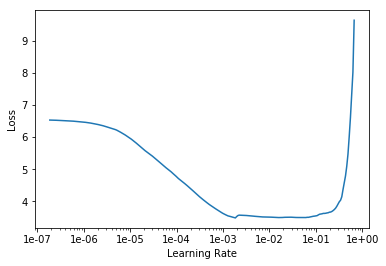

In [14]:
learn.lr_find(num_it=300)
learn.recorder.plot()

### Create Language learner

In [11]:
learn = learn.to_fp16()

In [12]:
learn.fit(10, 1e-4)

epoch,train_loss,valid_loss,accuracy


fp16 overflow. skipping batch. Scale: 65536
fp16 overflow. skipping batch. Scale: 32768.0


KeyboardInterrupt: 

In [20]:
learn.model[0].hidden[0].shape

torch.Size([8, 500, 768])

In [13]:
learn.lr_find(num_it=300)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: The size of tensor a (500) must match the size of tensor b (12) at non-singleton dimension 1

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/text/models/transformer.py(114)_apply_attention()
    112         AC = torch.matmul(wq+u,wk)
    113         BD = _line_shift(torch.matmul(wq+v, wkr))
--> 114         if self.scale: attn_score = (AC + BD).mul_(1/(self.d_head ** 0.5))
    115         if mask is not None:
    116             attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)

ipdb> wkr.shape
torch.Size([12, 64, 1000])
ipdb> d_head
*** NameError: name 'd_head' is not defined
ipdb> self.d_head
64
ipdb> self.n_heads
12
ipdb> seq_len
1000
ipdb> wq.shape
torch.Size([8, 12, 500, 64])


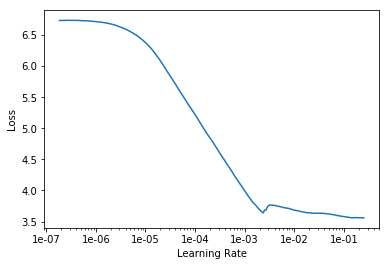

In [19]:
learn.recorder.plot()

In [23]:
2**10

1024

In [21]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy


fp16 overflow. skipping batch
fp16 overflow. skipping batch


KeyboardInterrupt: 

In [26]:
learn.validate()

[7.028072, tensor(0.4319)]

In [16]:
# learn = learn.to_fp16(32)

In [17]:
# learn.lr_find()

In [18]:
# learn.recorder.plot()

In [19]:
learn = learn.load('gpt_long_bptt_second_run')

In [28]:
learn.show_results()

text,target,pred
xxbos || t8 nD3 t8 || t0 nA4 t19 || t0 nA3 t2 || t1 nF3 t1 || t0 nA3,nD4 t3 || t0 nF4 t2 || t0 nF3 t1 nA3 t4 || t0 nF3 t1 || t2 nA3 t3,nC2 t25 nC#2 nC5 t77 t142 nG4 t105 nB-0 nE9 t110 t105 t148 t105 t124 nE9 t110 nC5 t51 t105
nF4 t5 || t0 nC5 t1 || t0 nG#4 t1 || t0 nG4 t1 nG#5 t1 nC6 t1 || t0,t56 || t1 nC5 t1 || t0 nG#4 t1 || t0 nG4 t1 nC6 t1 nF6 t1 || t0 nB-4,t25 nG5 t105 t110 t25 t110 t105 t83 t25 t110 t105 t124 t25 t110 t105 t110 nE9 t110 t252 t83
|| t0 nE-5 t5 nE5 t1 || t0 nC4 t63 nE4 t15 nC5 t4 nE5 t3 || t3 nC5 t7,t9 || t1 nE5 t2 || t0 nB4 t8 nD5 t28 || t0 nE5 t2 || t0 nB-4 t1 nC#5,t25 nC#6 t26 t126 t94 t77 t26 t87 t94 nB3 t25 t108 t26 t87 t94 t77 t26 t87 nG8 t77
|| t1 nB-5 t1 || t2 nB-6 t2 || t1 nB6 t4 || t0 nC7 t1 nB-7 t1 || t0,t1 nC1 t2 nD1 t2 nG#7 t2 nB-7 t1 || t1 nB0 t3 nC1 t3 || t0 nA0 t2 nD1,t94 t115 t256 t115 nC4 t115 t142 t115 t264 t110 nF#7 t110 t94 t115 t256 t115 t26 t83 nC4 t115
nB4 t1 nG#5 t1 nA5 t1 || t0 nE4 t1 nF5 t2 || t0 nD4 t1 || t0 nF5 t1,t0 nB3 t1 nG#4 t1 || t0 nE3 t1 nF4 t1 || t1 nG#3 t2 || t0 nB2 t1 ||,nF#7 nB-0 t105 t110 nE9 t111 nF#7 t126 t105 t77 t142 t72 t105 t77 t191 nC2 nF#7 t77 t48 t77


In [25]:
import music21
from music21 import *
from IPython.display import Image, Audio

In [26]:
def seq2stream(full_seq, seed=None):
    full_seq = full_seq.replace('xxbos ', '')
    note_stream = arrToStreamNotewise(full_seq.split(' '), sample_freq=sample_freq, note_offset=note_offset)
    if seed is None: return note_stream
    seed = seed.replace('xxbos ', '')
    pred_only = full_seq.replace(seed, '').strip()
    pred_only_stream = arrToStreamNotewise(pred_only.split(' '), sample_freq=sample_freq, note_offset=note_offset)
    return note_stream, pred_only_stream

In [28]:
idx = 1
folder_idx = 6 # 2 = bach
seed_len = 300

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

note_offset, sample_freq, file

IsADirectoryError: [Errno 21] Is a directory: 'data/midi/midi_transcribe_v3_shortdur/freemidi/genre-dance-eletric'

In [45]:
seed_stream = seq2stream(seed)

In [46]:
seed_stream.show('midi')

In [95]:
pred_out = learn.predict(seed, n_words=200)

In [96]:
note_stream, pred_stream = seq2stream(pred_out, seed)

In [64]:
note_stream.show('midi')

In [97]:
pred_stream.show('midi')

### Using beam search

In [ ]:
cuda_enabled=True
def get_x_input(partial):
    _, _, _, seq = partial
    max_len = bptt-50
    input = seq[-max_len:]
    input_var = torch.LongTensor([input])
    if cuda_enabled:
        input_var = input_var.cuda()
    return input_var.unsqueeze(dim=0)

# song = string
# seq_length = generated song length
# beam_size = what to choose from
def beam_search(seed, seq_length, beam_size, learn):    
    xb, yb = learn.data.one_item(seed)
    seed_list = xb.squeeze().tolist()
    learn.model.reset()
    partial_sequences = [(0, 0, [], seed_list)]
    
    for i in progress_bar(range(seq_length), leave=False):
        partial_sequences = find_partials(partial_sequences, beam_size, learn)
    final_sequence = partial_sequences[0][3] # 0 = highest prob, 3 = seq
    return learn.data.vocab.textify(final_sequence), final_sequence
    
def find_partials(partial_sequences, beam_size, learn, 
                  no_maj:bool=False, no_unk:bool=True, temperature:float=2., 
                  min_p:float=None, random=True):
    partial_next = []
    for partial in partial_sequences:
        it, tot_p, p_list, seq = partial
        x_input = get_x_input(partial)
        y = torch.zeros_like(x_input)
        
        predict_probs = learn.pred_batch(batch=(x_input,y)).squeeze()[-1]
        if no_unk: predict_probs[learn.data.vocab.stoi[UNK]] = 0.
        if no_maj: predict_probs[learn.data.vocab.stoi[TK_MAJ]] = 0.
        if min_p is not None: predict_probs[res < min_p] = 0.
        if temperature != 1.: predict_probs.pow_(1 / temperature)
            
            
        if random:
            idxs = torch.multinomial(predict_probs, beam_size)
            probs = predict_probs[idxs]
        else:
            # last_it_probs = torch.exp(predict_probs[-(it+1):]) # this is to predict the last few iterations
            last_it_probs = torch.exp(predict_probs)
            probs, idxs = torch.topk(last_it_probs, beam_size, 0)
        
        for prob,idx in zip(probs,idxs):
            new_p_list = p_list+[prob.item()]
            partial_next.append((it+1, np.mean(new_p_list), new_p_list, seq+[idx.item()]))

    partial_sequences = sorted(partial_next, key=lambda x: x[1], reverse=True)[:beam_size]
    return partial_sequences

In [1]:
pred_beam, idxs = beam_search(seed, seq_length=400, beam_size=3, learn=learn)

NameError: name 'beam_search' is not defined

In [ ]:
beam_stream, pred_beam_stream = seq2stream(pred_beam, seed)

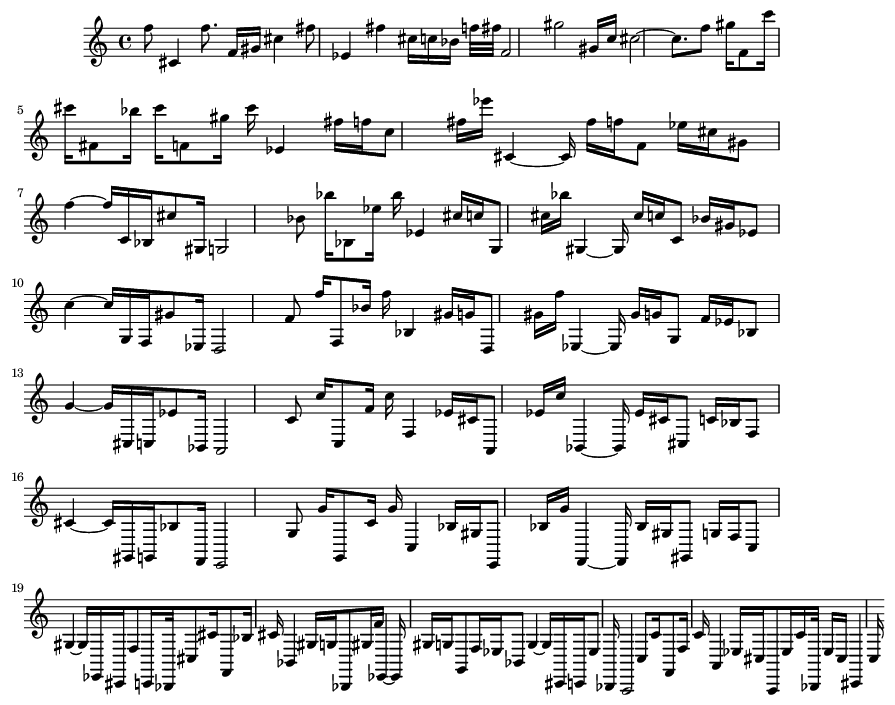

In [111]:
Image(filename=str(beam_stream.write('lily.png')))

In [112]:
beam_stream.show('midi')

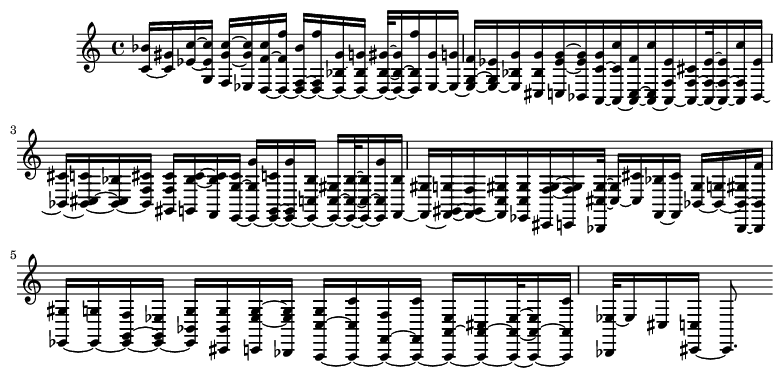

In [115]:
Image(filename=str(pred_beam_stream.chordify().write('lily.png')))

In [114]:
pred_beam_stream.show('midi')